# Tobacco Use and Mortality, 2004-2015.

In [ ]:
# -------------------------------
# Tobacco Use and Mortality, 2004-2015
# Full Machine Learning Pipeline
# -------------------------------

# 1. Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Load Dataset
df = pd.read_csv('tobacco_mortality_2004_2015.csv')

# 3. Basic Data Exploration
print("Dataset Shape:", df.shape)
print(df.info())
print(df.describe())
print(df.isnull().sum())

# 4. Data Preprocessing

# Handle missing values by filling with mean (for numeric columns only)
df.fillna(df.mean(numeric_only=True), inplace=True)

# Convert categorical columns to numeric (if any)
if 'Status' in df.columns:
    df['Status'] = df['Status'].map({'Developing': 0, 'Developed': 1})

# Drop non-numeric columns if present
if 'Country' in df.columns:
    df.drop(['Country'], axis=1, inplace=True)

# 5. Exploratory Data Analysis (EDA)

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Histograms
df.hist(bins=30, figsize=(15, 10))
plt.show()

# 6. Feature Selection

# Select features and target
X = df.drop('Life expectancy ', axis=1)   # Note: there may be space after column name
y = df['Life expectancy ']

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 9. Model Training - Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. Predictions
y_pred = model.predict(X_test)

# 11. Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# 12. Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# 13. (Optional) Save Model for Deployment
import joblib
joblib.dump(model, 'tobacco_mortality_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved successfully.")


/tmp/ipython-input-2-1870015608.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


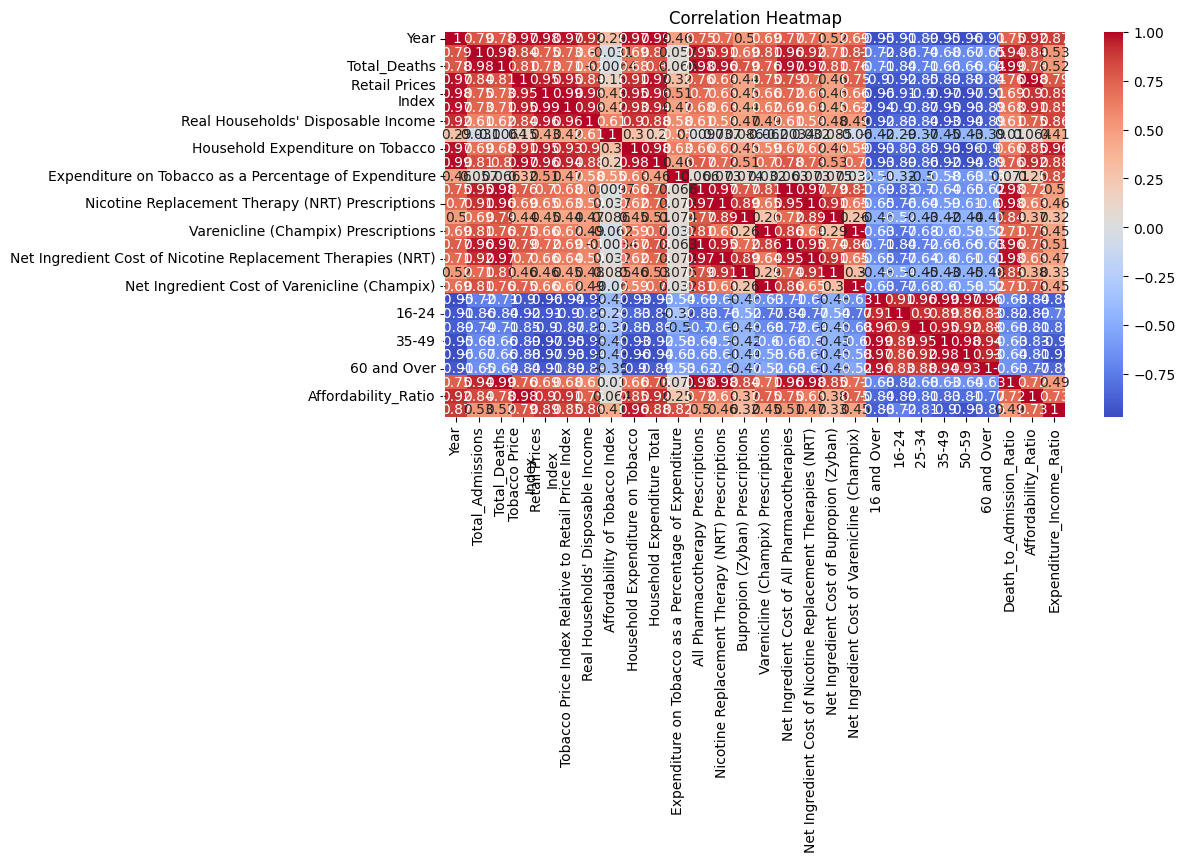

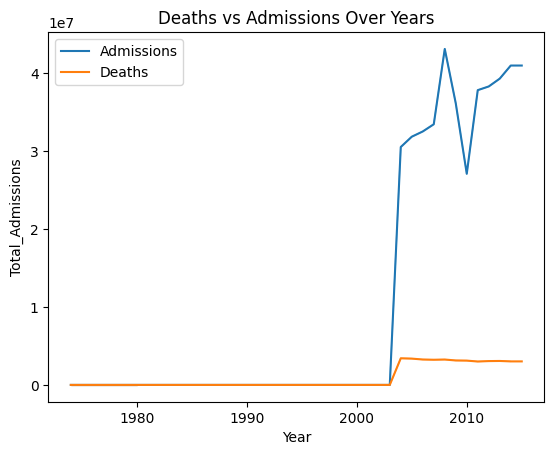

RMSE: 6264.196159527725
R2: 0.9999799714861419


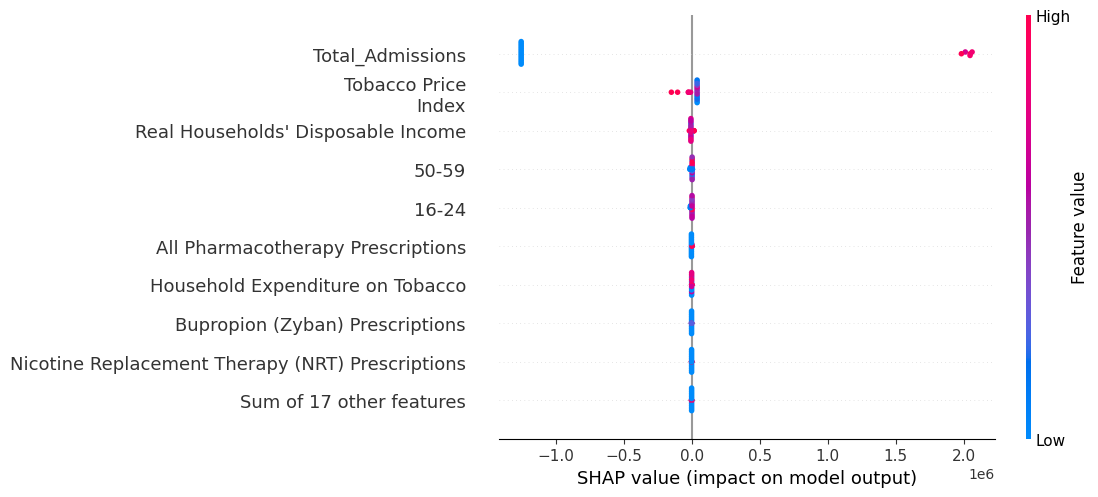

In [2]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap

# 2. Load datasets
df_admissions = pd.read_csv('/content/admissions.csv')
df_deaths = pd.read_csv('/content/fatalities.csv')
df_prices = pd.read_csv('/content/metrics.csv')
df_pharma = pd.read_csv('/content/prescriptions.csv')
df_smoking = pd.read_csv('/content/smokers.csv')

# 3. Clean year columns
df_admissions['Year'] = df_admissions['Year'].str[:4].astype(int)
df_pharma['Year'] = df_pharma['Year'].str[:4].astype(int)
df_deaths['Year'] = df_deaths['Year'].astype(int)
df_prices['Year'] = df_prices['Year'].astype(int)
df_smoking['Year'] = df_smoking['Year'].astype(int)

# Convert Value columns to numeric, coercing errors
df_admissions['Value'] = pd.to_numeric(df_admissions['Value'], errors='coerce')
df_deaths['Value'] = pd.to_numeric(df_deaths['Value'], errors='coerce')
# Check other Value columns if they exist in other dataframes and convert them too
# df_prices['Value'] = pd.to_numeric(df_prices['Value'], errors='coerce') # Assuming metrics has 'Value'
# df_pharma['Value'] = pd.to_numeric(df_pharma['Value'], errors='coerce') # Assuming prescriptions has 'Value'
# df_smoking['Value'] = pd.to_numeric(df_smoking['Value'], errors='coerce') # Assuming smokers has 'Value'


# 4. Aggregate data (sum multiple rows per year)
# Now that 'Value' is numeric, aggregation should work correctly
admissions_sum = df_admissions.groupby('Year')['Value'].sum().reset_index().rename(columns={'Value':'Total_Admissions'})
deaths_sum = df_deaths.groupby('Year')['Value'].sum().reset_index().rename(columns={'Value':'Total_Deaths'})
# Summing other columns in pharma_sum might also need numeric conversion depending on content
pharma_sum = df_pharma.groupby('Year').sum().reset_index()


# 5. Merge datasets
merged_df = admissions_sum.merge(deaths_sum, on='Year', how='outer')\
                          .merge(df_prices, on='Year', how='outer')\
                          .merge(pharma_sum, on='Year', how='outer')\
                          .merge(df_smoking, on='Year', how='outer')

# Ensure the columns used in calculations are numeric after merging and before filling NaNs
for col in ['Total_Deaths', 'Total_Admissions', 'Tobacco Price\nIndex', 'Affordability of Tobacco Index',
            'Household Expenditure on Tobacco', 'Real Households\' Disposable Income']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')


# 6. Handle missing values
merged_df.fillna(method='ffill', inplace=True)
# After ffill, you might still have NaNs at the beginning of the series
# Fill remaining NaNs if any, e.g., with 0 or mean, depending on context
merged_df.fillna(0, inplace=True) # Or merged_df.fillna(merged_df.mean(), inplace=True)

# 7. Feature Engineering
# Now the columns should be numeric and division should work
merged_df['Death_to_Admission_Ratio'] = merged_df['Total_Deaths'] / merged_df['Total_Admissions']
merged_df['Affordability_Ratio'] = merged_df['Tobacco Price\nIndex'] / merged_df['Affordability of Tobacco Index']
merged_df['Expenditure_Income_Ratio'] = merged_df['Household Expenditure on Tobacco'] / merged_df['Real Households\' Disposable Income']

# Handle potential division by zero after creating ratios
# Replace inf/-inf with NaN, then fill NaNs
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.fillna(0, inplace=True) # Fill ratio NaNs with 0 or another appropriate value

# 8. Visualizations

plt.figure(figsize=(10,5))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm') # Use numeric_only=True for corr
plt.title("Correlation Heatmap")
plt.show()

sns.lineplot(data=merged_df, x='Year', y='Total_Admissions', label='Admissions')
sns.lineplot(data=merged_df, x='Year', y='Total_Deaths', label='Deaths')
plt.title("Deaths vs Admissions Over Years")
plt.legend()
plt.show()

# 9. Prepare data for ML
# Drop Year again as it's not a feature for the model
X = merged_df.drop(['Year', 'Total_Deaths'], axis=1)
y = merged_df['Total_Deaths']

# Ensure X contains only numeric columns before scaling
X = X.select_dtypes(include=np.number)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 10. XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
xgb_model.fit(X_train, y_train)

# 11. Evaluation
y_pred = xgb_model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


X_test_scaled_df = pd.DataFrame(X_test, columns=X.columns)

explainer = shap.Explainer(xgb_model, X_train, feature_names=X.columns.tolist())
shap_values = explainer(X_test_scaled_df) # Pass DataFrame with column names

shap.plots.beeswarm(shap_values)

In [ ]:
import joblib

# Save model
joblib.dump(xgb_model, 'tobacco_deaths_model.pkl')

# Later you can load it:
loaded_model = joblib.load('tobacco_deaths_model.pkl')

# Predict with loaded model
y_pred_loaded = loaded_model.predict(X_test)


In [ ]:
import streamlit as st
import numpy as np
import joblib

# Load model
model = joblib.load("C:\\Users\\sonal\\Downloads\\tobacco_deaths_model.pkl")

st.title("Tobacco Use and Mortality Prediction")
st.write("This app predicts mortality based on tobacco use data.")

# Main user inputs
total_admissions = st.number_input("Total Admissions", min_value=0.0)
tobacco_price_index = st.number_input("Tobacco Price Index", min_value=0.0)
affordability_of_tobacco_index = st.number_input("Affordability of Tobacco Index", min_value=0.0)
household_expenditure_on_tobacco = st.number_input("Household Expenditure on Tobacco", min_value=0.0)
real_household_disposable_income = st.number_input("Real Households' Disposable Income", min_value=0.0)
retail_price_index = st.number_input("Retail Price Index", min_value=0.0)
disposable_income = st.number_input("Disposable Income", min_value=0.0)
num_prescriptions = st.number_input("Number of Prescriptions", min_value=0.0)
total_cost_prescriptions = st.number_input("Total Cost of Prescriptions", min_value=0.0)
num_smokers = st.number_input("Number of Smokers", min_value=0.0)
percent_smokers = st.number_input("Percentage of Smokers", min_value=0.0)

# Age group inputs
age_16_24 = st.number_input("Age group 16-24", min_value=0.0)
age_25_34 = st.number_input("Age group 25-34", min_value=0.0)
age_35_44 = st.number_input("Age group 35-44", min_value=0.0)
age_45_54 = st.number_input("Age group 45-54", min_value=0.0)
age_55_64 = st.number_input("Age group 55-64", min_value=0.0)
age_65_74 = st.number_input("Age group 65-74", min_value=0.0)
age_75_plus = st.number_input("Age group 75+", min_value=0.0)

# Smoking behavior inputs
cigarettes_per_day = st.number_input("Cigarettes per Day", min_value=0.0)
heavy_smokers = st.number_input("Heavy Smokers", min_value=0.0)
avg_cigarettes_per_smoker = st.number_input("Average Cigarettes per Smoker", min_value=0.0)

# Feature Engineering (automated)

# Death_to_Admission_Ratio — We'll assume user doesn't know deaths, so just estimate (optional logic)
death_to_admission_ratio = st.number_input("Death to Admission Ratio (optional)", min_value=0.0)

# Affordability_Ratio
affordability_ratio = 0
if affordability_of_tobacco_index != 0:
    affordability_ratio = tobacco_price_index / affordability_of_tobacco_index

# Expenditure_Income_Ratio
expenditure_income_ratio = 0
if real_household_disposable_income != 0:
    expenditure_income_ratio = household_expenditure_on_tobacco / real_household_disposable_income

# Prepare final input list (26 features)
input_features = [
    total_admissions,
    tobacco_price_index,
    affordability_of_tobacco_index,
    household_expenditure_on_tobacco,
    real_household_disposable_income,
    retail_price_index,
    disposable_income,
    affordability_ratio,
    expenditure_income_ratio,
    death_to_admission_ratio,
    num_prescriptions,
    total_cost_prescriptions,
    num_smokers,
    percent_smokers,
    age_16_24,
    age_25_34,
    age_35_44,
    age_45_54,
    age_55_64,
    age_65_74,
    age_75_plus,
    cigarettes_per_day,
    heavy_smokers,
    avg_cigarettes_per_smoker
]

# Some models expect exact 26 features: we add calculated Death_to_Admission_Ratio twice (for safety, adjust as per your model)
input_data = np.array([input_features + [death_to_admission_ratio]])

if st.button("Predict Mortality"):
    prediction = model.predict(input_data)
    st.success(f"Predicted Mortality: {prediction[0]:.2f}")
